# Evaluate Search Performance of MCTBP During Training
Do we find lower-energy structures during the search than were in the dataset to begin with?

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from fff.simulation.utils import read_from_string
from more_itertools import batched
from ase.db import connect
from pathlib import Path
from ase import units
import pandas as pd

## Load in the Data
We need data from WDBase and our training run.

### Training Run
Extract the number of waters in the cluster, where it came from, and its total energy. 

In [2]:
structures = []
with connect('../../../colmena/initial/runs/mp2-mctbp-23Jul29-162655-4a6b29/train.db') as db:
    for row in db.select(''):
        structures.append({
            'n_waters': row.natoms // 3,
            'energy': row.energy,
            'fmax': row.fmax,
            **row.key_value_pairs
        })
structures = pd.DataFrame(structures)

Label structures without a source as initial

In [3]:
structures.loc[structures['source'].isnull(), 'source'] = 'initial'

## WDBase
Parse the XYZ files I've downloaded from [WDBase](https://sites.uw.edu/wdbase/database-of-water-clusters/)

In [4]:
wdbase_energies = []
for mp2_path in Path('./wdbase/mp2-avtz-relaxed/').glob('*.txt'):
    n_waters = int(mp2_path.name.split("_")[0][1:])
    
    with mp2_path.open() as fp:
        for i, lines in enumerate(batched(fp, n_waters * 3 + 2)):  # Over each XYZ
            # Parse structure
            xyz = "".join(lines)
            energy = float(lines[1].split()[-1]) * units.Ha
            read_from_string(xyz, 'xyz')  # Make sure it parses
            
            # Store the energies
            wdbase_energies.append({
                'n_waters': n_waters,
                'index': i,
                'energy': energy,
                'xyz': xyz
            })
wdbase_energies = pd.DataFrame(wdbase_energies)

## Plot Energies wrt Known Minimum over Time
Assume that the minimum energy of the initial training structures or WDBase's AVTZ energies is the putative groundstate.

In [5]:
my_best_energy = structures.query('source=="initial"').groupby('n_waters')['energy'].min().reset_index()
wdbase_best_energy = wdbase_energies.groupby('n_waters')['energy'].min().reset_index()

Get the overall best

In [6]:
best_energy = my_best_energy.merge(wdbase_best_energy, on='n_waters', suffixes=('_mine', '_wdbase'), how='outer')

In [7]:
best_energy['energy'] = best_energy[['energy_mine', 'energy_wdbase']].min(axis=1)

In [8]:
best_energy.set_index('n_waters', inplace=True)

In [9]:
structures['above_min'] = structures['energy'] - structures['n_waters'].apply(lambda x: best_energy.loc[x, 'energy'])

Plot the energies of the structures

Text(0, 0.5, '$E - E_{min}$ (kcal/mol/water)')

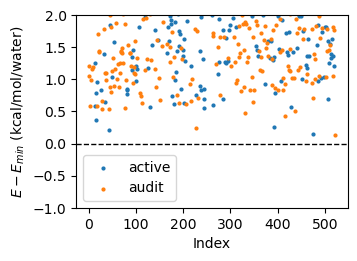

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

conv = units.mol / units.kcal
starting_new = structures.query('source != "initial"').index.min()
for gid, group in structures.query('source != "initial"').groupby('source'):
    ax.scatter(group.index - starting_new, group['above_min'] / group['n_waters'] * conv, label=gid, s=4)
    
ax.legend()
ax.set_xlim(ax.get_xlim())
ax.set_ylim(-1, 2)

ax.plot(ax.get_xlim(), [0.0] * 2, 'k--', lw=1)

ax.set_xlabel('Index')
ax.set_ylabel('$E - E_{min}$ (kcal/mol/water)')